# Visualizing Predictions

We need to visualize the predictions to see how bad each model is, so we can choose the optimal model later.
All of the records should be in this folder as a .npz file.

In [13]:
import numpy as np
import os
from pathlib import Path
from collections import defaultdict
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
current_dir = Path.cwd()
records = current_dir.glob('*.npz')

In [15]:
print(list(records))

[PosixPath('/home/reddi-rtx/ml/lecture/testnight-faster_rcnn_resnet101_lowproposals_coco.npz'), PosixPath('/home/reddi-rtx/ml/lecture/testnight-faster_rcnn_resnet101_coco.npz'), PosixPath('/home/reddi-rtx/ml/lecture/testday-ssd_inception_v2_coco.npz'), PosixPath('/home/reddi-rtx/ml/lecture/testday-ssd_resnet50_v1_fpn.npz'), PosixPath('/home/reddi-rtx/ml/lecture/testnight-ssd_inception_v2_coco.npz'), PosixPath('/home/reddi-rtx/ml/lecture/testday-faster_rcnn_resnet101_lowproposals_coco.npz'), PosixPath('/home/reddi-rtx/ml/lecture/testday-faster_rcnn_resnet101_coco.npz'), PosixPath('/home/reddi-rtx/ml/lecture/testnight-ssd_resnet50_v1_fpn.npz')]


In [16]:
video2records = defaultdict(dict)
for record_file in current_dir.glob('*.npz'):
    basename = record_file.name.replace(record_file.suffix, "")
    video, model = basename.split('-')
    video2records[video][model] = np.load(record_file)

In [5]:
video2records

defaultdict(dict,
            {'testnight': {'faster_rcnn_resnet101_lowproposals_coco': <numpy.lib.npyio.NpzFile at 0x7fcdf0305550>,
              'faster_rcnn_resnet101_coco': <numpy.lib.npyio.NpzFile at 0x7fcdf03248d0>,
              'ssd_inception_v2_coco': <numpy.lib.npyio.NpzFile at 0x7fcdf0324c18>,
              'ssd_resnet50_v1_fpn': <numpy.lib.npyio.NpzFile at 0x7fcdf0330128>},
             'testday': {'ssd_inception_v2_coco': <numpy.lib.npyio.NpzFile at 0x7fcdf0324a90>,
              'ssd_resnet50_v1_fpn': <numpy.lib.npyio.NpzFile at 0x7fcdf0324c50>,
              'faster_rcnn_resnet101_lowproposals_coco': <numpy.lib.npyio.NpzFile at 0x7fcdf0324f60>,
              'faster_rcnn_resnet101_coco': <numpy.lib.npyio.NpzFile at 0x7fcdf0324f28>}})

In [6]:
def viz_image(image, bboxes):
    # Get the current reference
    h, w, _ = image.shape
    plt.figure(figsize=(14, 12))
    plt.imshow(image)
    ax = plt.gca()
    scaled_bboxes = bboxes * [h, w, h, w]
    for y1, x1, y2, x2 in scaled_bboxes:
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=1, edgecolor='r',
                             facecolor='none')
        ax.add_patch(rect)
    plt.show()

We also need a good way to filter out some of the really bad bounding boxes.
These can be the large ones.
Also, the class corresponding to humans is class id 1, so we can also filter by that.

In [7]:
def filter_bboxes(bboxes, classes, scores, only_people=True, score=0.2, area_filter=0.1):
    if only_people:
        indices = (classes == 1)
        bboxes = bboxes[indices]
        classes = classes[indices]
        scores = scores[indices]
    
    # We can also filter by score threshold
    indices = (scores > score)
    bboxes, classes, scores = bboxes[indices], classes[indices], scores[indices]
    
    # We can also filter by how large the bbox is.
    dx = bboxes[:, 2] - bboxes[:, 0]
    dy = bboxes[:, 3] - bboxes[:, 1]
    indices = (dx * dy) < area_filter
    return bboxes[indices]

In [8]:
VIDEO_DIR = Path(os.environ["HOME"]) / 'videos'

In [9]:
import matplotlib.gridspec as gridspec

def visualize_video(video_name, bboxes_dict, frame_number):
    """Takes in a video name, a dictionary of size 4 with the key as the network and
    the npz folder as the label, and frame number to visualize."""
    cap = cv2.VideoCapture(str(VIDEO_DIR/video_name))
    # Skip to the frame number we want
    for _ in range(frame_number):
        ret, frame = cap.read()
    ret, frame = cap.read()
    
    plt.figure(figsize=(28, 18))
    plt.rcParams.update({'font.size': 16})
    # Set the spacing a little bit tighter
    gs = gridspec.GridSpec(2, 2)
    gs.update(wspace=0.025, hspace=0)
    count = 0
    for model, rec in bboxes_dict.items():
        bboxes = rec['bboxes'][frame_number]
        scores = rec['scores'][frame_number]
        classes = rec['classes'][frame_number]
        bboxes = filter_bboxes(bboxes, classes, scores)
        if count > 3:
            break
        plt.subplot(gs[count])
        h, w, _ = frame.shape
        plt.title(model)
        plt.imshow(frame)
        ax = plt.gca()
        plt.axis('off')
        plt.xlabel(model)
        scaled_bboxes = bboxes * [h, w, h, w]
        for y1, x1, y2, x2 in scaled_bboxes:
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=1, edgecolor='r',
                                 facecolor='none')
            ax.add_patch(rect)
        count += 1
    plt.show()

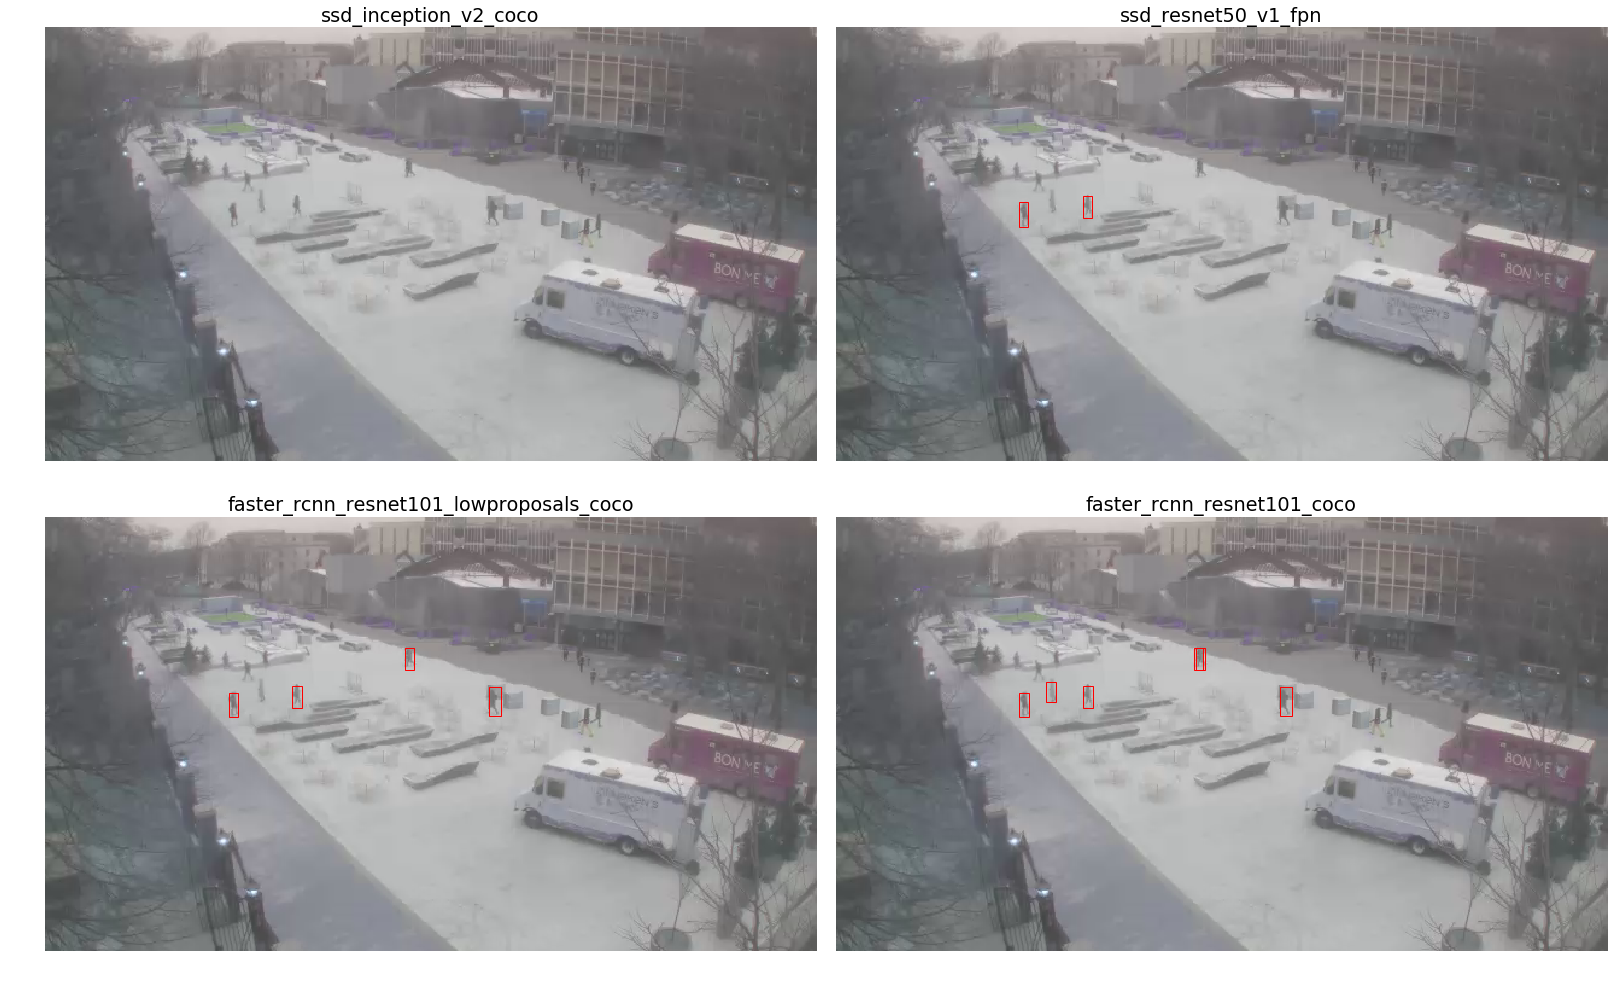

In [10]:
visualize_video('testday.mkv', video2records['testday'], 1)

In [11]:
import tqdm
from pathlib import Path

def save_video(video_name, bboxes_dict, num_frames, save_prefix):
    """Takes in a video name, a dictionary of size 4 with the key as the network and
    the npz folder as the label, and frame number to visualize."""
    cap = cv2.VideoCapture(str(VIDEO_DIR/video_name))
    # Skip to the frame number we want
    
    for k in tqdm.tqdm(range(num_frames)):
        ret, frame = cap.read()

        plt.figure(figsize=(28, 18))
        plt.rcParams.update({'font.size': 16})
        # Set the spacing a little bit tighter
        gs = gridspec.GridSpec(2, 2)
        gs.update(wspace=0.025, hspace=0)
        count = 0

        for model, rec in bboxes_dict.items():
            bboxes = rec['bboxes'][k]
            scores = rec['scores'][k]
            classes = rec['classes'][k]
            inftime = rec['inftime']
            bboxes = filter_bboxes(bboxes, classes, scores)
            if count > 3:
                break
            plt.subplot(gs[count])
            h, w, _ = frame.shape
            plt.title(model + "\t" + "Inftime: {} s".format(inftime))
            plt.imshow(frame)
            ax = plt.gca()
            plt.axis('off')
            plt.xlabel(model)
            scaled_bboxes = bboxes * [h, w, h, w]
            for y1, x1, y2, x2 in scaled_bboxes:
                rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=1, edgecolor='r',
                                     facecolor='none')
                ax.add_patch(rect)
            count += 1
        plt.savefig("%s%06d.png" % (save_prefix, k))
        plt.close()

In [12]:
# save_video('testday.mkv', video2records['testday'], 8000, "/tmp/test/day")
save_video('testnight.mkv', video2records['testnight'], 1200, "/tmp/test/night")

100%|██████████| 1200/1200 [09:45<00:00,  2.11it/s]
